In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [23]:
data = pd.read_csv('Discriminant-analysis-churn-dataset.csv')
data.dropna()
data.head()

,account_length,number_vmail_messages,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,number_customer_service_calls,churn
0,128,25,45.07,16.78,11.01,2.70,1,0
1,107,26,27.47,16.62,11.45,3.70,1,0
2,137,0,41.38,10.30,7.32,3.29,0,0
3,84,0,50.90,5.26,8.86,1.78,2,0
4,75,0,28.34,12.61,8.41,2.73,3,0


In [24]:
no_class = data['churn'].value_counts()
no_classes = len(no_class)
no_classes

2

In [25]:
column_names = data.columns.values
column_names

array(['account_length', 'number_vmail_messages', 'total_day_charge',
       'total_eve_charge', 'total_night_charge', 'total_intl_charge',
       'number_customer_service_calls', 'churn'], dtype=object)

In [27]:
def readInput(col):
    print('Features are : \n' + '\n'.join(col))
    text = input(
        "Enter features with comma seperator: ")
    dep = input(
        "Enter Dependent Variable : ")
    arr = text.split(",")
    return arr,dep

features,dep = readInput(column_names)

## account_length,number_vmail_messages,total_day_charge,total_eve_charge,total_night_charge,total_intl_charge,number_customer_service_calls

Features are : 
account_length
number_vmail_messages
total_day_charge
total_eve_charge
total_night_charge
total_intl_charge
number_customer_service_calls
churn
Enter features with comma seperator: account_length,number_vmail_messages
Enter Dependent Variable : churn


In [28]:
y = data[dep].values
X = data[features].values

### Find Mean Vectors


In [29]:
cols = len(X[0])
rows = len(X)

In [30]:
mean_vectors = []
for cl in range(0,no_classes):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl]))

Mean Vector class 0: [99.91707431  8.29187049]

Mean Vector class 1: [102.33239038   4.49646393]



### Scatter Matrix within 

In [31]:
S_W = np.zeros((cols,cols))
for cl,mv in zip(range(1,cols), mean_vectors):
    class_sc_mat = np.zeros((cols,cols))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(cols,1), mv.reshape(cols,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[1099923.35074156    9407.18670706]
 [   9407.18670706  100297.15457723]]


### Scatter Matrix Between

In [32]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((cols,cols))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(cols,1) # make column vector
    overall_mean = overall_mean.reshape(cols,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[  82.46433787 -129.58373927]
 [-129.58373927  203.62675449]]


### Eigen vector and eigen value pairs

In [33]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(cols,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.84365571]
 [-0.53688457]]
Eigenvalue 1: 0.00e+00

Eigenvector 2: 
[[ 0.06607601]
 [-0.99781459]]
Eigenvalue 2: 2.13e-03


### Sorting in decreasing order and picking top k values, max = c-1

In [34]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

print('Eigenvalues in percentage:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))



Eigenvalues in decreasing order:

0.002129015099385173
0.0
Eigenvalues in percentage:

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%


### Selecting Linear Discriminants

In [35]:
W = np.hstack((eig_pairs[0][1].reshape(cols,1), eig_pairs[1][1].reshape(cols,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.06607601 -0.84365571]
 [-0.99781459 -0.53688457]]


### Transforming to new space

In [36]:
X_lda = X.dot(W)
assert X_lda.shape == (rows,2), "The matrix is not 150x2 dimensional."

### Plotting

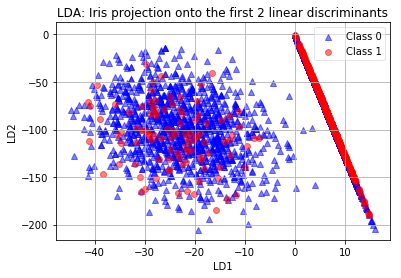

In [37]:
label_dict = {1: 'Class 1', 0: 'Class 0'}

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,2),('^', 'o'),('blue', 'red')):


        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )
     

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()